In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

import streamlit as st

In [37]:
df=pd.read_csv(r'/workspaces/PYTHON_ML/projects/Datasets/qs_worldranking_cleaned.csv')

In [38]:
df.columns

Index(['RANK_2025', 'RANK_2024', 'Institution_Name', 'Location', 'Region',
       'SIZE', 'FOCUS', 'RES.', 'STATUS', 'Academic_Reputation_Score',
       'Academic_Reputation_Rank', 'Employer_Reputation_Score',
       'Employer_Reputation_Rank', 'Faculty_Student_Score',
       'Faculty_Student_Rank', 'Citations_per_Faculty_Score',
       'Citations_per_Faculty_Rank', 'International_Faculty_Score',
       'International_Faculty_Rank', 'International_Students_Score',
       'International_Students_Rank', 'International_Research_Network_Score',
       'International_Research_Network_Rank', 'Employment_Outcomes_Score',
       'Employment_Outcomes_Rank', 'Sustainability_Score',
       'Sustainability_Rank', 'Overall_Score'],
      dtype='object')

In [39]:
#Training Data Selection. For overall Score
df_train = df[df['Overall_Score'].notnull()]
df_train.shape

(593, 28)

In [40]:
# Selecting Features and Target
features = [
    'Academic_Reputation_Score', 'Employer_Reputation_Score', 'Faculty_Student_Score',
    'Citations_per_Faculty_Score', 'International_Faculty_Score', 'International_Students_Score',
    'International_Research_Network_Score', 'Employment_Outcomes_Score', 'Sustainability_Score',
    'Region', 'SIZE'
]

target = 'Overall_Score'



In [41]:
#Log-transform numerical scores 
#In my Language- Log transformation is used to reduce skewness,stable variance and make data more normally distributed
df_training = df_train.copy()
num_features = features[:-3]
for col in num_features:
    df_training[col] = np.log1p(df_training[col])

In [42]:
df_training.columns

Index(['RANK_2025', 'RANK_2024', 'Institution_Name', 'Location', 'Region',
       'SIZE', 'FOCUS', 'RES.', 'STATUS', 'Academic_Reputation_Score',
       'Academic_Reputation_Rank', 'Employer_Reputation_Score',
       'Employer_Reputation_Rank', 'Faculty_Student_Score',
       'Faculty_Student_Rank', 'Citations_per_Faculty_Score',
       'Citations_per_Faculty_Rank', 'International_Faculty_Score',
       'International_Faculty_Rank', 'International_Students_Score',
       'International_Students_Rank', 'International_Research_Network_Score',
       'International_Research_Network_Rank', 'Employment_Outcomes_Score',
       'Employment_Outcomes_Rank', 'Sustainability_Score',
       'Sustainability_Rank', 'Overall_Score'],
      dtype='object')

In [43]:
df_training.shape

(593, 28)

In [44]:
#making preprocessing pipeline for efficiency
pre_processor = ColumnTransformer([
    ('num', StandardScaler(), num_features),
    ('region', OneHotEncoder(drop='first', handle_unknown='ignore'), ['Region']),
    ('size', OrdinalEncoder(categories=[['S', 'M', 'L', 'XL']]), ['SIZE'])
])

In [45]:
# making the - Model pipeline
pipeline = Pipeline([
    ('preprocessor', pre_processor),
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))
])

In [46]:
# Split data
X = df_training[features]
y = df_training[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=X['Region'], random_state=42)

In [49]:
# Train and evaluate with cross-validation
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print(f"MSE: {mean_squared_error(y_test, y_pred):.2f}")
print(f"R²: {r2_score(y_test, y_pred):.2f}")
cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='r2')
print(f"Cross-Validation R²: {cv_scores.mean():.2f} ± {cv_scores.std():.2f}")

MSE: 18.27
R²: 0.95
Cross-Validation R²: -2.11 ± 0.92


<Figure size 1000x600 with 0 Axes>

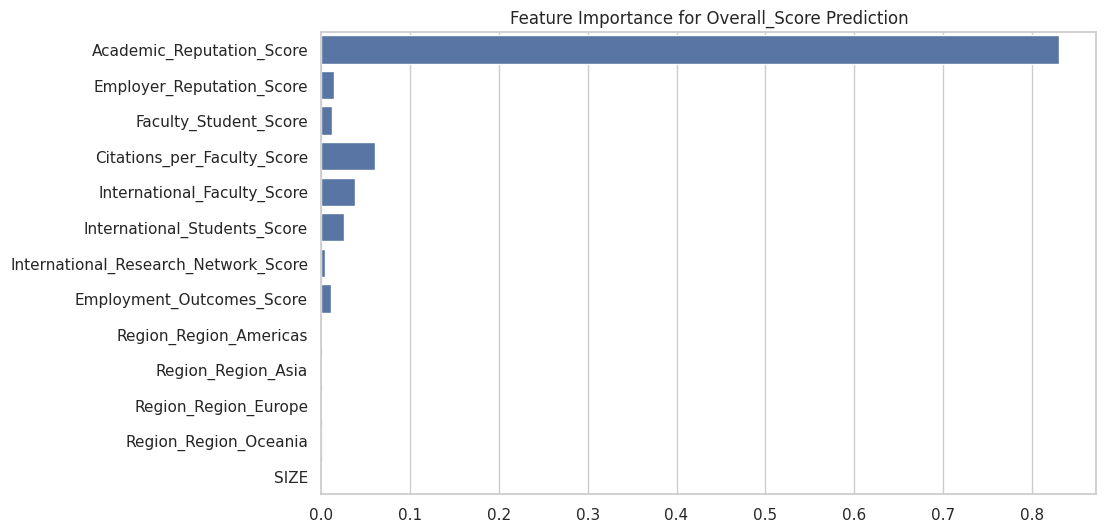

In [53]:
#Feature Importance
plt.figure(figsize=(10, 6))
sns.set(style='whitegrid')
# Extracting feature importances from the model
feature_names = (num_features + 
                 [f"Region_{r}" for r in pipeline.named_steps['preprocessor'].named_transformers_['region'].get_feature_names_out(['Region'])] + 
                 ['SIZE'])
importances = pipeline.named_steps['model'].feature_importances_
plt.figure(figsize=(10, 6))
sns.barplot(x=importances, y=feature_names)
plt.title('Feature Importance for Overall_Score Prediction')
plt.show()

/tmp/ipykernel_2232/3562244971.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_missing[col] = np.log1p(X_missing[col])
/home/codespace/.local/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Predicted dataset saved as 'qs_rankings_predicted.csv'


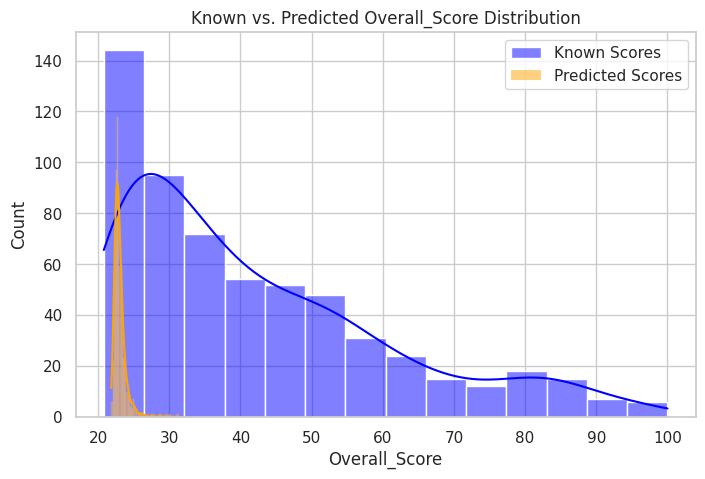

In [55]:
df_missing = df[df['Overall_Score'].isnull()].copy()
if not df_missing.empty:
    X_missing = df_missing[features]
    for col in num_features:
        X_missing[col] = np.log1p(X_missing[col])
    df_missing['Overall_Score'] = pipeline.predict(X_missing)
    df_full = pd.concat([df_train, df_missing])
    #df_full.to_csv('qs_rankings_predicted.csv', index=False)
    print("Predicted dataset saved as 'qs_rankings_predicted.csv'")
    
    # Validate distribution
    plt.figure(figsize=(8, 5))
    sns.histplot(df_train['Overall_Score'], label='Known Scores', kde=True, color='blue')
    sns.histplot(df_missing['Overall_Score'], label='Predicted Scores', kde=True, color='orange')
    plt.title('Known vs. Predicted Overall_Score Distribution')
    plt.legend()
    plt.show()


In [56]:
#function for predicting university score
def predict_university_score(university_name, dataset, model):
    uni_row = dataset[dataset['Institution_Name'].str.lower() == university_name.lower()]
    if uni_row.empty:
        return f"University '{university_name}' not found."
    X_uni = uni_row[features]
    for col in num_features:
        X_uni[col] = np.log1p(X_uni[col])
    score = model.predict(X_uni)[0]
    return f"Predicted Overall_Score for {university_name}: {score:.2f}"

In [75]:
predict_university_score("AGH University of Science and Technology", df_full, pipeline)

/tmp/ipykernel_2232/719709045.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_uni[col] = np.log1p(X_uni[col])


'Predicted Overall_Score for AGH University of Science and Technology: 22.86'

In [58]:
df['Institution_Name']

0       Massachusetts Institute of Technology (MIT) 
1                            Imperial College London
2                               University of Oxford
3                                 Harvard University
4                            University of Cambridge
                            ...                     
1380                 University of Montana Missoula 
1381                            University of Oradea
1382                        University of San Carlos
1383        University Politehnica of Timisoara, UPT
1384                   Western Washington University
Name: Institution_Name, Length: 1385, dtype: object